In [2]:
import logging
import os
import sys

sys.path.append('../')

from typing import List, Callable, NoReturn, NewType, Any
from datasets import load_metric, load_from_disk, Dataset, DatasetDict

from tqdm.notebook import tqdm, trange
import numpy as np
import pandas as pd

from transformers import AutoConfig, AutoModelForQuestionAnswering, AutoTokenizer
from transformers import (
    DataCollatorWithPadding,
    EvalPrediction,
    HfArgumentParser,
    TrainingArguments,
    set_seed,
)

from retrieval import SparseRetrieval

from utils_qa import postprocess_qa_predictions, check_no_error
from trainer_qa import QuestionAnsweringTrainer

from arguments import (
    ModelArguments,
    DataTrainingArguments,
    LoggingArguments,
)

from custom_tokenizer import load_pretrained_tokenizer

from dotenv import load_dotenv
from preprocessor import Preprocessor

## Argument

In [3]:
model_args = ModelArguments
data_args = DataTrainingArguments
training_args = TrainingArguments

In [4]:
set_seed(training_args.seed)

## Wiki Data

In [5]:
import json

data_path="/opt/ml/data/"
context_path= "wikipedia_documents.json"
with open(os.path.join(data_path, context_path), "r", encoding="utf-8") as f:
    wiki = json.load(f)

In [6]:
wiki_data = []

for key in wiki.keys() :
    data = wiki[key]
    wiki_data.append(data['text'])

## Preprocessing

In [7]:
wiki_data = Preprocessor.preprocessing(wiki_data, pt_num = "13")

## Data Size

In [8]:
print('Size of Wiki Data : %d'%len(wiki_data))

Size of Wiki Data : 55963


In [9]:
from nltk.tokenize import sent_tokenize

In [10]:
wiki_passages  = []
for doc in wiki_data :
    sen_list = sent_tokenize(doc)
    wiki_passages.append(sen_list)

wiki_doc_len = [len(doc) for doc in wiki_passages if len(doc) < 100]

In [11]:
import matplotlib.pyplot as plt

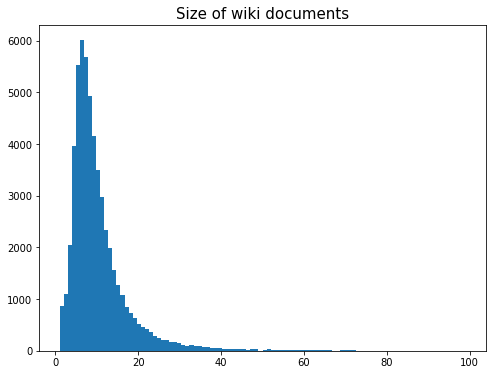

In [12]:
plt.figure(figsize=(8,6))
plt.title('Size of wiki documents', fontsize=15)
plt.hist(wiki_doc_len, bins=100)
plt.show()

## ICT Data

In [13]:
pseudo_queries = []
pseudo_contexts = []

In [14]:
for doc in tqdm(wiki_passages) :
    sen_size = len(doc)
    for i in range(0,sen_size,7) :
        if i + 7 > sen_size :
            continue
        query = doc[i+3]
        context = doc[i:i+3] + doc[i+4:i+7]
        context = ' '.join(context)

        pseudo_queries.append(query)
        pseudo_contexts.append(context)
 

In [15]:
print('Example of pseudo query\n%s' %pseudo_queries[0])

Example of pseudo query
# 두 번째 부분은 일부 지역의 주권을 사실상 (데 팍토) 행사하고 있지만, 아직 국제적인 승인을 널리 받지 않았다고 여기는 11개 나라를 나열하고 있다.


In [16]:
print('Example of pseudo context\n%s ' %pseudo_contexts[0])

Example of pseudo context
이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개요 형태로 나열하고 있다. 이 목록은 명료화를 위해 두 부분으로 나뉘어 있다. # 첫 번째 부분은 바티칸 시국과 팔레스타인을 포함하여 유엔 등 국제 기구에 가입되어 국제적인 승인을 널리 받았다고 여기는 195개 나라를 나열하고 있다. 두 목록은 모두 가나다 순이다. 일부 국가의 경우 국가로서의 자격에 논쟁의 여부가 있으며, 이 때문에 이러한 목록을 엮는 것은 매우 어렵고 논란이 생길 수 있는 과정이다. 이 목록을 구성하고 있는 국가를 선정하는 기준에 대한 정보는 "포함 기준" 단락을 통해 설명하였다. 


In [17]:
print('ICT Data Size : %d' %len(pseudo_contexts))

ICT Data Size : 57499


## Tokenizer

In [18]:
model_args.model_name_or_path = 'klue/bert-base'
tokenizer = AutoTokenizer.from_pretrained(model_args.model_name_or_path, use_fast=True)

/opt/conda/lib/python3.8/site-packages/transformers/configuration_utils.py:336: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [19]:
tokenizer

PreTrainedTokenizerFast(name_or_path='klue/bert-base', vocab_size=32000, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [20]:
q_seqs = tokenizer(pseudo_queries, 
    padding="max_length", 
    truncation=True, 
    return_tensors='pt')

p_seqs = tokenizer(pseudo_contexts, 
    padding="max_length", 
    truncation=True, 
    return_tensors='pt')

## Seed

In [21]:
from tqdm import tqdm, trange
import random
import torch
import torch.nn.functional as F
from torch.utils.data import (DataLoader, RandomSampler, TensorDataset)
from transformers import BertModel, BertPreTrainedModel, AdamW, TrainingArguments, get_linear_schedule_with_warmup

torch.manual_seed(2021)
torch.cuda.manual_seed(2021)
np.random.seed(2021)
random.seed(2021)

## Data

In [22]:
ict_dataset = TensorDataset(p_seqs['input_ids'], 
    p_seqs['attention_mask'], 
    p_seqs['token_type_ids'], 
    q_seqs['input_ids'], 
    q_seqs['attention_mask'], 
    q_seqs['token_type_ids'])

## Model

In [23]:
class BertEncoder(BertPreTrainedModel):
    def __init__(self, config):
        super(BertEncoder, self).__init__(config)

        self.bert = BertModel(config)
        self.init_weights()
      
    def forward(self, input_ids, 
        attention_mask=None, token_type_ids=None): 
  
        outputs = self.bert(input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)
      
        pooled_output = outputs[1]
        return pooled_output

In [24]:
torch.cuda.empty_cache()
p_encoder = BertEncoder.from_pretrained(model_args.model_name_or_path)
q_encoder = BertEncoder.from_pretrained(model_args.model_name_or_path)

if torch.cuda.is_available() :
    p_encoder.cuda()
    q_encoder.cuda()

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertEncoder: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at klue/bert-base were not used when initializing BertEncoder: ['cls.predictions.tr

## Training

In [25]:
import torch
import torch.nn.functional as F
from itertools import chain
from transformers import BertModel, BertPreTrainedModel, AdamW, TrainingArguments, get_linear_schedule_with_warmup

In [26]:
def progressLearning(value, endvalue, loss, bar_length=50):
    percent = float(value + 1) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))
    sys.stdout.write("\r[{0}] {1}/{2} \t Loss : {3:.3f}".format(arrow + spaces, value+1, endvalue, loss))
    sys.stdout.flush()

In [27]:
def train(args, dataset, p_model, q_model):
    train_sampler = RandomSampler(dataset)
    train_dataloader = DataLoader(dataset, 
        sampler=train_sampler, 
        batch_size=args.per_device_train_batch_size
    )

    model_parameters = chain(p_model.parameters(), q_model.parameters())
    optimizer = AdamW(model_parameters, 
        lr=args.learning_rate, 
        weight_decay=args.weight_decay
    )

    t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, 
        num_warmup_steps=args.warmup_steps, 
        num_training_steps=t_total
    )

    optimizer.zero_grad()
    p_model.zero_grad()
    q_model.zero_grad()
    torch.cuda.empty_cache()
  
    global_step = 0
    min_loss = np.inf

    for i in range(int(args.num_train_epochs)) :
        q_model.train()
        p_model.train()

        mean_loss = 0.0
        print('Epoch : %d' %i)
        for step, batch in enumerate(train_dataloader):
            
            if torch.cuda.is_available():
                batch = tuple(t.cuda() for t in batch)

            p_inputs = {'input_ids': batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2]
            }
      
            q_inputs = {'input_ids': batch[3],
                'attention_mask': batch[4],
                'token_type_ids': batch[5]
            }

            p_outputs = p_model(**p_inputs)  # (batch_size, emb_dim)
            q_outputs = q_model(**q_inputs)  # (batch_size, emb_dim)

            # Calculate similarity score & loss
            sim_scores = torch.matmul(q_outputs, torch.transpose(p_outputs, 0, 1))  # (batch_size, emb_dim) x (emb_dim, batch_size) = (batch_size, batch_size)

            # target: position of positive samples = diagonal element 
            targets = torch.arange(0, args.per_device_train_batch_size).long()
            if torch.cuda.is_available():
                targets = targets.to('cuda')

            sim_scores = F.log_softmax(sim_scores, dim=1)
            loss = F.nll_loss(sim_scores, targets)

            progressLearning(step, len(train_dataloader), loss.item())
            mean_loss += loss.item()
     
            loss.backward()
            optimizer.step()
            scheduler.step()

            optimizer.zero_grad()
            q_model.zero_grad()
            p_model.zero_grad()
            global_step += 1
      
        mean_loss /= len(train_dataloader)

        if mean_loss < min_loss :
            min_loss = loss 
            torch.save({'steps' : global_step,
                'p_encoder_state_dict' : p_model.state_dict() , 
                'q_decoder_state_dict' : q_model.state_dict() , 
                'loss' : mean_loss}, 
            os.path.join(args.output_dir, 'ict_pretrained.pt'))
        print('\nMean Loss : %.3f\n' %(mean_loss))
      
    return p_model, q_model


In [28]:
args = TrainingArguments(
    output_dir="./model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    num_train_epochs=6,
    warmup_steps=4000,
    weight_decay=1e-2
)

In [29]:
p_encoder, q_encoder = train(args, ict_dataset, p_encoder, q_encoder)

Epoch : 0
[---->                                             ] 1392/14375 	 Loss : 0.000

KeyboardInterrupt: 